### Numerical Experiments

First experiment: adaptivity of the sparse grid is tested

In [5]:
import openml

from openml import tasks

import HPO

import pysgpp

import sys

import math
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import sklearn.metrics

from sklearn.model_selection import cross_val_score

import numpy as np
import keras
from keras import backend as K

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from scikeras.wrappers import KerasRegressor, KerasClassifier


BUDGET = 30
VERBOSE = 1
CV = [(slice(None), slice(None))]
SCORING = 'neg_mean_squared_error'
TESTING = False

DATASETS = []


### Hyperparameter space definition

In [6]:
ADAPTIVITIES = [0.75, 0.85, 0.9, 0.95, 1]

hyperparameterspace = {
    'epochs': ["interval-int", 1, 30],
    'batch_size': ["interval-int", 10, 200],
    'optimizer__learning_rate': ["interval-log", 0.0000001, 0.01],
    'model__neurons_per_layer': ["interval-int", 1, 100],
    'model__number_of_layers': ["interval-int", 1, 10],
}

hyperparameterspace_special = {}
for key in hyperparameterspace.keys():
    liste = []
    for i in range(1, len(hyperparameterspace[key])):
        liste.append(hyperparameterspace[key][i])
    hyperparameterspace_special[key] = liste

In [7]:
ids = [233214, 233211, 359935, 359952, 359940]#, 359931, 317614, 359949, 359934, 359946, 359938, 359932, 359943]

def relu_advanced(x):
    return K.relu(x)

ACTIVATION_FUNCTION = relu_advanced

RESULTS_datasets = [[] for _ in range(len(ids))]

valid_datasets = 0
for i in range(len(ids)):

    dataset = HPO.Dataset(task_id=ids[i])

    class ExampleFunction(pysgpp.ScalarFunction):

        def __init__(self):
            super(ExampleFunction, self).__init__(len(hyperparameterspace.keys()))


        def eval(self, x):
            #index = int(x[0]*(len(hyperparameterspace_special["loss"])-1))
            loss = 'mean_squared_error'#hyperparameterspace_special["loss"][index]
            
            epochs = int(HPO.from_standard(hyperparameterspace_special["epochs"][0], hyperparameterspace_special["epochs"][1], x[0]))

            batch_size = int(HPO.from_standard(hyperparameterspace_special["batch_size"][0], hyperparameterspace_special["batch_size"][1], x[1]))

            model_learning_rate = HPO.from_standard_log(hyperparameterspace_special["optimizer__learning_rate"][0], hyperparameterspace_special["optimizer__learning_rate"][1], x[2])
            
            neurons_per_layer = int(HPO.from_standard(hyperparameterspace_special["model__neurons_per_layer"][0], hyperparameterspace_special["model__neurons_per_layer"][1], x[3]))

            number_of_layers = int(HPO.from_standard(hyperparameterspace_special["model__number_of_layers"][0], hyperparameterspace_special["model__number_of_layers"][1], x[4]))

            # Function to create model, required for KerasClassifier
            def create_model():
                # create model
                model = Sequential()
                model.add(Dense(neurons_per_layer, input_shape=(len(dataset.get_X()[0]),), activation=ACTIVATION_FUNCTION))
                for _ in range(number_of_layers):
                    model.add(Dense(neurons_per_layer, activation=ACTIVATION_FUNCTION))
                model.add(Dense(1, activation=None))
                # Compile model
                
                optimizer = keras.optimizers.Adam(learning_rate=model_learning_rate)

                model.compile(loss=loss, optimizer=optimizer,)
                return model

            model = KerasRegressor(model=create_model, verbose=0)

            model.fit(dataset.get_X_train(), dataset.get_Y_train(), epochs=epochs, batch_size=batch_size)

            if TESTING:
                Y_predicted = model.predict(dataset.get_X_test())
                result = sklearn.metrics.mean_squared_error(dataset.get_Y_test().tolist(), Y_predicted)
                K.clear_session()
                return result
            else:
                Y_predicted = model.predict(dataset.get_X_validation())
                result = sklearn.metrics.mean_squared_error(dataset.get_Y_validation().tolist(), Y_predicted)
                K.clear_session()
                return result


    results_temp = []
    results_opt_temp = []

    for adaptivity in ADAPTIVITIES:
        print("Current adaptivity:", adaptivity)

        sparse_params=[3, adaptivity, "gradient_descent"]

        f = ExampleFunction()

        optimization = HPO.SparseGridSearchOptimization(dataset, f, hyperparameterspace, budget=BUDGET, verbosity=VERBOSE, degree=sparse_params[0], adaptivity=sparse_params[1], optimizer=sparse_params[2])

        result = optimization.fit()

        TESTING = True
        results_temp.append(f.eval(result[0]))
        results_temp.append(f.eval(result[1]))
        TESTING = False

    for m in range(len(results_temp)):
        RESULTS_datasets[i].append(results_temp[m])


Current adaptivity: 0.75
Adaptive grid generation (Ritter-Novak)...


: 

: 

### Plotting

[[0.8203195427954444, 0.818853497098821, 0.8545141504718555, 0.8516326041613894]]
Task with id 233214


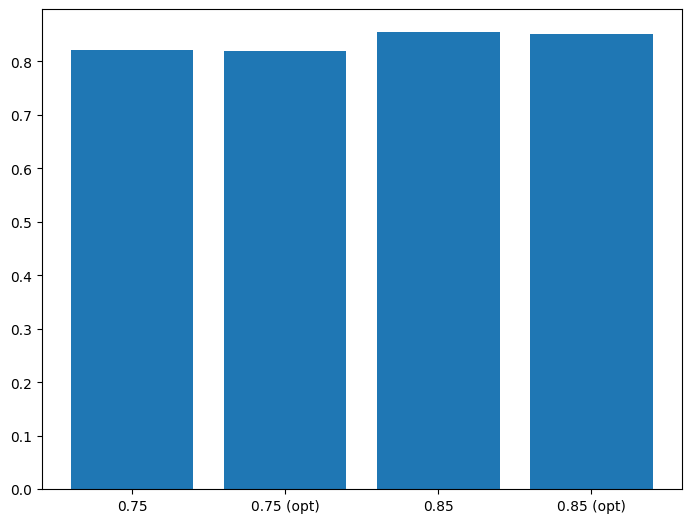

In [ ]:
print(RESULTS_datasets)

for i in range(len(ids)):
    print("Task with id", ids[i])

    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])

    opts = []
    k = 0
    for adaptivity in ADAPTIVITIES:
        opts.append(str(adaptivity))
        opts.append(str(adaptivity)+" (opt)")
        k += 1

    ax.bar(opts, RESULTS_datasets[i])
    # plt.ylim(0.9*min(RESULTS_datasets[i]), None)
    plt.show()

